In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch 
from tqdm.notebook import tqdm #used as a progress bar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

In [ ]:
review_df   = pd.read_json('/content/drive/My Drive/Amazon_Product_Sentiment_IE/Electronics_5.json',orient='records', lines=True)
review_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [ ]:
# Changes the overall category to categorical from numerical.
review_df["classes"] = review_df["overall"]
review_df["classes"].replace({5.0: "positive",4.0:"positive",3.0:"neutral",2.0:"negative",1.0:"negative"}, inplace=True)
review_df["classes"].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [ ]:
# Dropping null values to have a cleaner dataset
review_df = review_df.dropna(subset=['reviewText'])

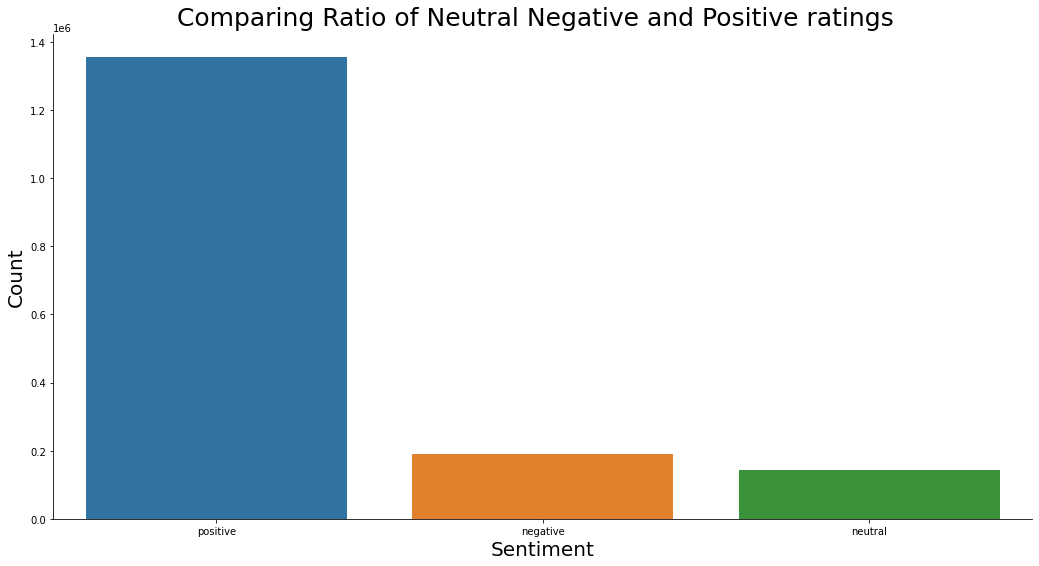

In [ ]:
# Distribution of sentiment class
fig, axes = plt.subplots(1, figsize=(15,8))
fig.suptitle("Comparing Ratio of Neutral Negative and Positive ratings", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "classes", data = review_df)
axes.set_xlabel("Sentiment", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
sns.despine()

In [ ]:
# Percentage of neutral, negative, positive words in train and test data
def pert_count(data, category):
    return (len(data[data["classes"] == category])/len(data)) * 100
print(f"Percentage of neutral words in train --> {pert_count(review_df, 'neutral')} %")
print(f"Percentage of negative words in train --> {pert_count(review_df, 'negative')} %")
print(f"Percentage of positive words in train --> {pert_count(review_df, 'positive')} %")

Percentage of neutral words in train --> 8.421620328820712 %
Percentage of negative words in train --> 11.299156754606356 %
Percentage of positive words in train --> 80.27922291657293 %


In [ ]:
# Most repeated words in reviews
stopwords = set(STOPWORDS)
def word_cloud(data, title):
    wordcloud = WordCloud(
    background_color = "black",
    max_font_size = 40,
    max_words = 200,
    stopwords = stopwords,
    scale = 3).generate(str(data))
    fig = plt.figure(figsize = (7.5, 7.5))
    plt.axis("off")
    if title: 
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=2.25)
    plt.imshow(wordcloud)
    plt.show()

In [ ]:
# seperating all records into a different variable to generate wordcloud based on category
neu=review_df[review_df["classes"] == "neutral"]["reviewText"]
neg=review_df[review_df["classes"] == "negative"]["reviewText"]
pos=review_df[review_df["classes"] == "positive"]["reviewText"]

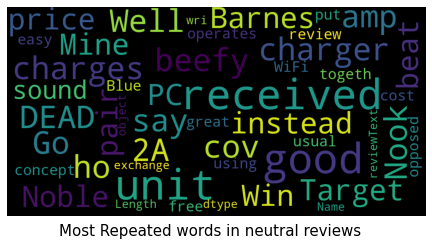

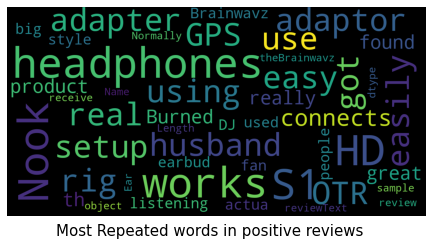

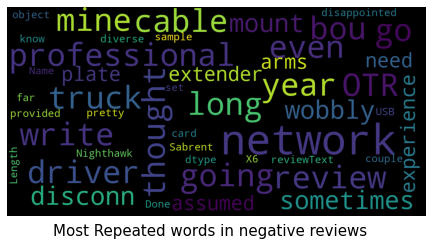

In [ ]:
# Generating wordcloud based on category
word_cloud(neu, "Most Repeated words in neutral reviews")
word_cloud(pos, "Most Repeated words in positive reviews")
word_cloud(neg, "Most Repeated words in negative reviews")

In [ ]:
# Function for bigram
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n] 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


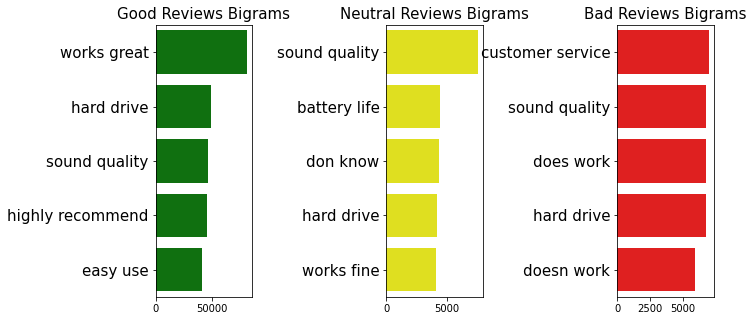

In [ ]:
# create a function for bigram plots
def n_gram_plot(data,title,color):
    x=[x[0] for x in data]
    y=[x[1] for x in data]
    sns.barplot(y,x,color='{}'.format(color))
    plt.title('{} Reviews Bigrams'.format(title),fontsize=15)
    plt.yticks(rotation=0,fontsize=15)

common_words_good = get_top_n_bigram(pos, 5)
common_words_neutral= get_top_n_bigram(neu, 5)
common_words_bad= get_top_n_bigram(neg, 5)

# bigram plot using function above
plt.figure(figsize=(10,5))
# good reviews bigrams
plt.subplot(151)
n_gram_plot(common_words_good,'Good','green')
#============================================= 
#neutral reviews bigrams
plt.subplot(153)
n_gram_plot(common_words_neutral,'Neutral','yellow')
#============================================= 
#bad reviews bigrams
plt.subplot(155)
n_gram_plot(common_words_bad,'Bad','red')
plt.show()

In [ ]:
#Preprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import nltk
import re
import string
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# splits review rating into different classes, say positive(2), neutral(1) and negative(0). 
def classify(x):
    if x == 5.0 or x==4.0:
        return 2
    if x==3.0:
        return 1 
    return 0

In [ ]:
def clean_dataframe(df):
  # creates new column with corresponding class labels, the output variable.
  df['y'] = df['overall'].apply(classify)

  # dropping uneccesary columns for the analysis
  df = df.drop(labels=['asin' ,'reviewerID','helpful','reviewerName','summary','unixReviewTime','reviewTime'],axis=1)
  
  # dropping all NaN values from the column reviewText
  df = df.dropna(axis=0, subset=['reviewText'])
  return df

In [ ]:
# removes all the punctuations for the strings of reviewText, ie '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

In [ ]:
def text_process(df):
  # Removing all the punctuations from the words, and changing the words to lower case to maintain uniformity
  df['reviewText']=df['reviewText'].apply(lambda x: remove_punctuation(x.lower()))
  # stemming
  stemmer = PorterStemmer()
  # stop words are the words like "the, I, our etc"
  words = stopwords.words("english") 
  df['cleaned_reviews'] = df['reviewText'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
  return df

In [ ]:
def process_df(df):
  df = clean_dataframe(df)
  df = text_process(df)
  return df

In [ ]:
# reading dataset and writing cleaned version to it
cleaned_dataset = '/content/drive/My Drive/Amazon_Product_Sentiment_IE/Electronics_Cleaned_.csv'
def main(CLEAN=cleaned_dataset):
  print("UNCLEANED DATASET HEAD:\n",review_df.head(),"\n")

  df_clean = process_df(review_df)
  print("CLEANED DATASET HEAD:\n",df_clean.head(),"\n")

  #writing to dataframe
  df_clean.to_csv(cleaned_dataset)
main()

UNCLEANED DATASET HEAD:
        reviewerID        asin  ... unixReviewTime   reviewTime
0   AO94DHGC771SJ  0528881469  ...     1370131200   06 2, 2013
1   AMO214LNFCEI4  0528881469  ...     1290643200  11 25, 2010
2  A3N7T0DY83Y4IG  0528881469  ...     1283990400   09 9, 2010
3  A1H8PY3QHMQQA0  0528881469  ...     1290556800  11 24, 2010
4  A24EV6RXELQZ63  0528881469  ...     1317254400  09 29, 2011

[5 rows x 9 columns] 

CLEANED DATASET HEAD:
                                           reviewText  ...                                    cleaned_reviews
0  we got this gps for my husband who is an otr o...  ...  got gp husband otr road trucker impress ship t...
1  im a professional otr truck driver and i bough...  ...  im profession otr truck driver bought tnd truc...
2  well what can i say  ive had this unit in my t...  ...  well say ive unit truck four day prior garmin ...
3  not going to write a long review even thought ...  ...  go write long review even thought unit deserv ...
4  iv